#### Проект по предсказанию стоимости жилья

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2]:
TRAIN_DATASET_PATH = 'C:/Users/FAMILY/Desktop/МАЯК/GeekBrains/NUMPY_MATPLOTLIB_SC-LEARN/Проект_исходная/project_data_from_kaggle/train.csv'
TEST_DATASET_PATH = 'C:/Users/FAMILY/Desktop/МАЯК/GeekBrains/NUMPY_MATPLOTLIB_SC-LEARN/Проект_исходная/project_data_from_kaggle/test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.loc[train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']]
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


#### Проверка равенства числа столбцов в тестовом и обучающем ДатаСете (обучающий ДатаСет за вычетом целевого столбца имеет равное количество столбцов с тестовым ДатаСетом)

In [5]:
train_df.shape[1]-1 == test_df.shape[1]

True

#### Проверка типов данных, содержащихся в ДатаСете, на предмет выявления НЕ числовых типов данных

In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [7]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

#### Данные по ID и DistrictId не являются коррелирующим признаком между зависимой (ценой) переменной и независимой (набор признаков) переменной, а отражают только порядковый номер записи дискретного состояния зависимой и независимой переменных. Поэтому для исключения ее из модели, переопределим ее на НЕ числовой тип данных.

In [8]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

#### Общая оценка выборки

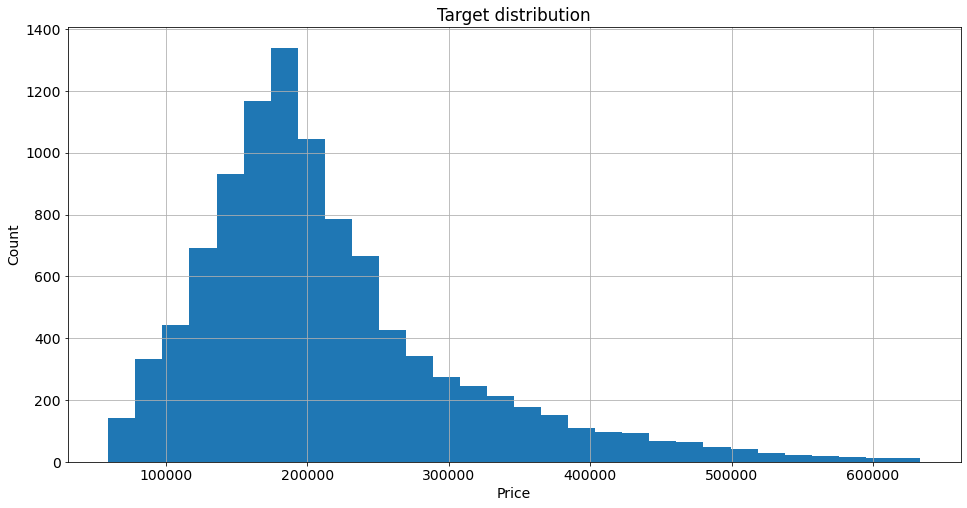

In [9]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [10]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Необходима обработка пропусков в столбцах LifeSquare, Healthcare_1

In [11]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### Вводим метку корректировки признака LifeSquare

In [12]:
train_df['LifeSquare_NaN']=0
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_NaN'] = 1

#### Заполняем пропуски в LifeSquare медианным зачением

In [13]:
median = train_df['LifeSquare'].median()
train_df['LifeSquare'] = train_df['LifeSquare'].fillna(median)

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_NaN
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.211300
std,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.408251
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


In [15]:
train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

#### Столбец 'Healthcare_1' имеет пропуски, но в то же время по смыслу характеризует некую насыщенность (доступность и т.д.) объекта медицинским обслуживанием. Соответственно, незаполненность данной графы скорее всего не свидетельствует об отсутствии медицины для данного объекта; следовательно, для соблюдения целостности модели (не исключения данного признака из расчета) имеет смысл заменить пропуски на наиболее частое значение (моду). Также в списке присутствует нулевое значение доступности медицины: вероятнее всего это выброс - заменим его тоже на моду. 

In [16]:
train_df['Healthcare_1_NaN']=0
train_df.loc[(train_df['Healthcare_1'].isna()) | (train_df['Healthcare_1'] == 0), 'Healthcare_1_NaN'] = 1

In [17]:
mode = train_df['Healthcare_1'].mode()
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(mode.loc[0])
train_df['Healthcare_1'].isna().sum()

0

In [18]:
train_df['Healthcare_1'][9995]

540.0

#### Обработка выбросов

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

#### Выбросом в данном столбце является наличие 0 и, скорее всего, более 6-ти комнат. Отработаем их так: 0 - 1 комната, 6 и более - по медиане

In [20]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

In [21]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [23]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

#### Отработаем кухню по квантилю 2,5% (отбросим мин и макс по 2,5% от выборки)

In [22]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

#### Обрабатываем правую границу медианой и вводим условие обработки на случай возможных пропусков - NaN (они могут быть в тестовой выборке)

In [23]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

#### В мин границу ничего не попало, поэтомму принимаем волевое решение о мин площади кухни 3 м2

In [24]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

#### Этажность 

In [25]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

#### Под этажностью 0 скорее всего имелся ввиду цокольный этаж, поэтому примем его как 1-й этаж. Этажи 99 и 117 явная ошибка, их обработаем медианой

In [26]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

In [27]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1
train_df.loc[train_df['HouseFloor'] > 48, 'HouseFloor'] = train_df['HouseFloor'].median()

In [28]:
(train_df['Floor'] > train_df['HouseFloor']).value_counts()

False    8182
True     1818
dtype: int64

#### Проверка соответствия этажа и этажности показала превышение этажа над этажностью дома в без малого четверти домов, что является ошибкой. Обработаем заменой этажа случайным образом, но не превышающим этажность

In [29]:
train_df['Floor_outlier'] = 0
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor_outlier'] = 1

In [30]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### Оценка поля - год постройки

In [31]:
train_df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int64

#### Обработаем выброс года постройки следующим образом: дома из "будущего" будем переопределять на текущий год постройки

In [32]:
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear_outlier'] = 1        
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

In [33]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
LifeSquare_NaN        0
Healthcare_1_NaN      0
Rooms_outlier         0
HouseFloor_outlier    0
Floor_outlier         0
HouseYear_outlier     0
dtype: int64

In [34]:
train_df.loc[train_df['LifeSquare'] + train_df['KitchenSquare'] > train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN,Healthcare_1_NaN,Rooms_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier
8,9951,1,1.0,46.887892,44.628132,3.0,12,20.0,1977,0.007122,...,0,1,B,160400.401732,0,1,0,0,0,0
19,367,45,1.0,42.367289,40.012529,3.0,7,14.0,2015,0.195781,...,3,2,B,250466.980777,0,1,0,0,1,0
33,847,74,2.0,73.314975,74.131261,3.0,1,6.0,1977,0.075779,...,0,2,B,254005.381863,0,1,0,0,1,0
34,7757,27,2.0,58.783661,55.441256,11.0,12,12.0,1977,0.011654,...,0,0,B,138396.984612,0,1,0,0,1,0
37,1699,9,1.0,78.936164,76.746654,3.0,5,7.0,1977,0.161532,...,2,4,B,226206.962435,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,...,3,6,B,87556.385617,0,0,0,0,0,0
9965,6441,52,3.0,85.796885,85.305246,3.0,15,17.0,1977,0.371149,...,2,5,B,204462.983720,0,0,0,0,0,0
9979,2201,6,1.0,40.043234,41.984322,3.0,3,17.0,2014,0.243205,...,0,0,B,134888.083598,0,0,0,0,0,0
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,...,0,1,B,203908.192698,0,1,0,0,0,0


#### Проверка соответствия общей площади сумме жилой площади и кухни показала несоответствие в 10% случаев. Даннаяя ошибка вызвана тем, что ранее была проведена обработка пропусков и выбросов по жилой площади и кухне, что привело к возникновению арифметической ошибки за счет замены на медиану и т.д. без учета соблюдения равенства "общая=жилая+кухня". Тем не менее просмотр исходного Датафрейма показал, что и там имеются подобные откллонения, но в меньшем количестве (всего 845 несоответствий). В данном случа примем волевым решением принятые корректировки жилой площади и кухни, а общую оставим "как есть", иначе это приведет к уходу от первоначальных значений и искажению модели

#### Далее попытка все вышеперечисленное объединить в класс для унификации кода (класс написан не самостоятельно, только адаптирован под задачу, т.е. в классе свое - это обработка LifeSquare и Healthcare_1

In [5]:
class DataPreprocessing():
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.modes = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Отработка квантиля
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        # Расчет моды
        self.modes = X.mode()
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Отработка Rooms
        
        X['Rooms_outlier'] = 0
        X.loc[(train_df['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
        X.loc[train_df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Отработка KitchenSquare
        
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # Отработка LifeSquare
        
        X['LifeSquare_NaN']=0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_NaN'] = 1
        
        X['LifeSquare'] = X['LifeSquare'].fillna(self.medians['LifeSquare'])
        
        # Отработка HouseFloor
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        X.loc[X['HouseFloor'] > 48, 'HouseFloor'] = self.medians['HouseFloor']
        
        # Отработка Floor
        X['Floor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor_outlier'] = 1
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # Отработка Healthcare_1
        
        X['Healthcare_1_NaN'] = 0
        X.loc[(X['Healthcare_1'].isna()) | (X['Healthcare_1'] == 0), 'Healthcare_1_NaN'] = 1
        X['Healthcare_1'] = X['Healthcare_1'].fillna(self.modes['Healthcare_1'].loc[0])
        
        # Отработка HouseYear
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > datetime.now().year, 'HouseYear_outlier'] = 1        
        X.loc[X['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year
        
        X.fillna(self.medians, inplace=True)
        
        return X
    

#### Запуск кода на построение модели (через классы Питон)

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_NaN,HouseFloor_outlier,Floor_outlier,Healthcare_1_NaN,HouseYear_outlier
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,0,1,0,0,1,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,0,0,0,0
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,0,1,0,0,1,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,0,0,0,0,1,0


#### Формирование новых признаков

#### Перевод вещественных Ecology_2, Ecology_3, Shops_2 в числовые путем бинатного кодирования

In [7]:
train_df.select_dtypes(include='object').columns.tolist()
print(train_df['Ecology_2'].value_counts())
print(train_df['Ecology_3'].value_counts())
print(train_df['Shops_2'].value_counts())


B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


#### Хоть значений А мало по сравнению с В, но пренебрегать ими не стоит

In [8]:
rain_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'])], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'])], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'])], axis=1)

#### Закодируем идентификатор района через его частоту исходя из гипотезы: чем чаще район встречается, тем весомее этот признак при расчете целевого значения

In [9]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [10]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')

In [11]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_NaN,HouseFloor_outlier,Floor_outlier,Healthcare_1_NaN,HouseYear_outlier,A,B,A,B,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,1,0,0,1,0,0,1,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,1,0,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,1,0,1,652
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,1,0,0,1,0,0,1,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,1,0,0,1,0,1,89


#### Рассмотрим частотность выпадения района: середина выборки прриходится на значение 100

In [12]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

#### Закодируем бинарно значения до и после условной середины выборки

In [13]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [42]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_NaN,HouseFloor_outlier,Floor_outlier,Healthcare_1_NaN,HouseYear_outlier,A,B,A,B,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,1,0,0,1,0,0,1,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,1,0,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,1,0,1,652
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,1,0,0,1,0,0,1,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,1,0,0,1,0,1,89


#### Средняя стоимость квартиры в зависимости от района

In [14]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})

In [15]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [16]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Floor_outlier,Healthcare_1_NaN,HouseYear_outlier,A,B,A,B,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,0,1,0,0,1,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,1,0,1,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,1,0,1,652,1,244005.272380
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,0,1,0,0,1,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,1,0,0,1,0,1,89,0,201584.441255


#### Формируем класс для генерации новых признаков 

In [17]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None

    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
   
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
                       
        return X

In [18]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'Healthcare_1']

In [50]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'LifeSquare_NaN',
 'HouseFloor_outlier',
 'Floor_outlier',
 'Healthcare_1_NaN',
 'HouseYear_outlier',
 'A',
 'B',
 'A',
 'B',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [19]:
new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'Floor_outlier', 'HouseYear_outlier', 'A', 'B', 'A', 'B', \
                     'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict']

In [20]:
target_name = 'Price'

#### Разбиение на тренировку и тестирование

In [21]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [23]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [24]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

In [25]:
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [88]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [79]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### Построение модели RandomForestRegressor (не оптимальная модель)

In [26]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

In [27]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

In [28]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Выводить R2 и строит графики для оценки качества модели
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()


Train R2:	0.96
Test R2:	0.748


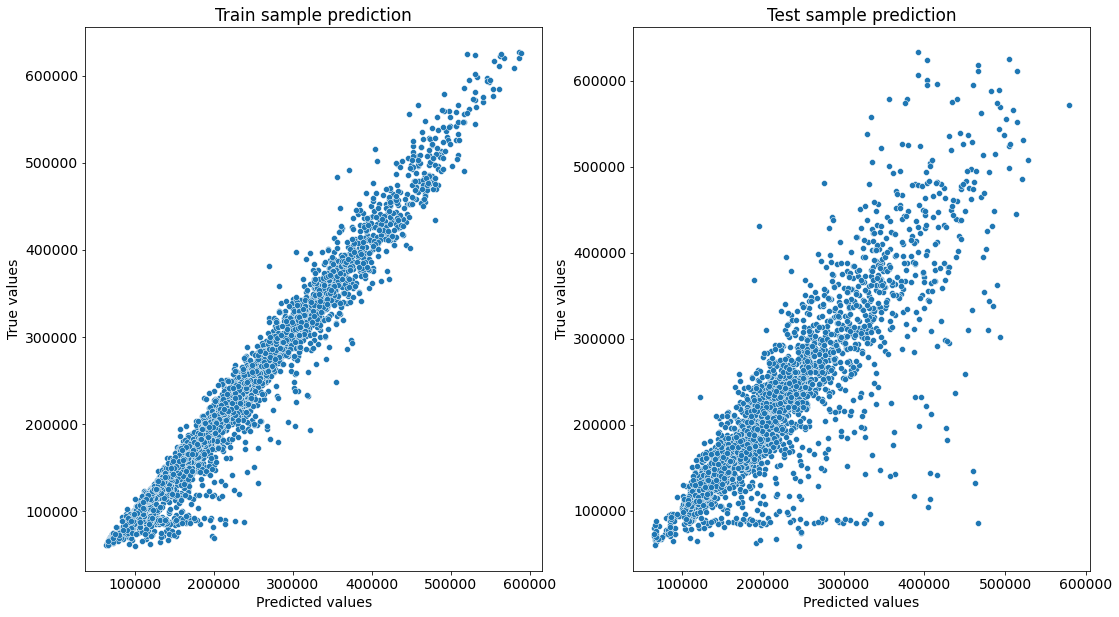

In [63]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [29]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73066437, 0.75628668, 0.75340703])

In [30]:
cv_score.mean()

0.7467860261720206

In [67]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.418526
25,DistrictSize,0.212802
14,Social_3,0.051338
8,HouseYear,0.031448
9,Ecology_1,0.029526
2,Rooms,0.029240
1,DistrictId,0.028265
13,Social_2,0.027935
0,Id,0.026512
4,LifeSquare,0.026106


#### Модель линейной регрессии (наиболее оптимальная модель)

In [68]:
lr = LinearRegression()
gb = GradientBoostingRegressor()

In [71]:
stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(criterion='mse',
                                                     random_state=21))],
                  final_estimator=GradientBoostingRegressor())

In [72]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

Train R2:	0.937
Test R2:	0.743


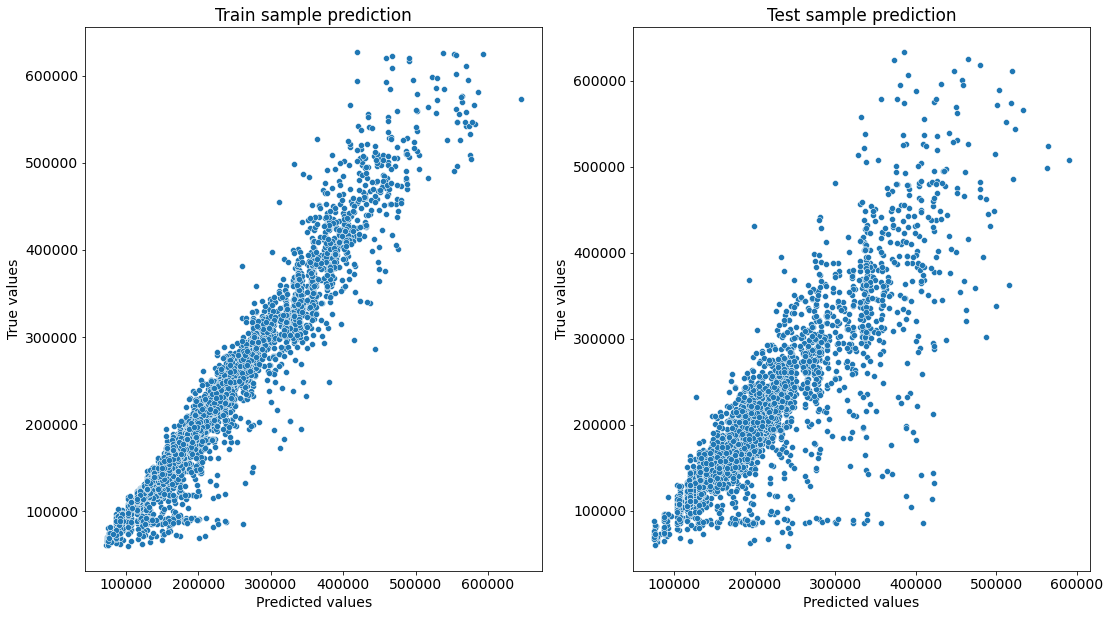

In [73]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [74]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73155194, 0.66349048, 0.71533048])

In [70]:
cv_score.mean()

0.7030386360516929

In [89]:
test_df.shape

(5000, 28)

In [75]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Rooms_outlier,LifeSquare_NaN,HouseFloor_outlier,Floor_outlier,Healthcare_1_NaN,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1,0,0,0,0,0,0,76.0,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,0,0,0,1,0,164.0,0,1
2,960,27,2.0,59.463678,32.679351,9.0,19,19.0,1977,0.211401,...,1,0,1,0,0,1,0,580.0,0,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,1,0,0,0,0,1,0,372.0,0,1
4,746,74,1.0,53.837056,32.679351,3.0,8,17.0,1977,0.309479,...,1,0,1,0,0,0,0,65.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,3,5.0,1962,0.069660,...,1,0,0,0,1,1,0,56.0,0,0
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,...,1,0,0,0,0,0,0,26.0,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,...,1,0,0,0,0,0,0,54.0,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,...,1,0,0,0,0,1,0,40.0,0,0


#### Построение целевого предсказания

In [31]:
predictions = stack.predict(test_df)
predictions
#to_csv('rf_submit.csv', index=False)

array([163649.47599676, 121061.42716713, 138335.63564373, ...,
       145521.91923631, 182487.83092908, 251901.6718461 ])

In [32]:
sample_submission = pd.read_csv('C:/Users/FAMILY/Desktop/МАЯК/GeekBrains/NUMPY_MATPLOTLIB_SC-LEARN/Проект_исходная/project_data_from_kaggle/sample_submission.csv')
sample_submission.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [33]:
sample_submission['Price'] = predictions
sample_submission.head()

,Id,Price
0,4567,163649.475997
1,5925,121061.427167
2,960,138335.635644
3,3848,154905.491639
4,746,179244.129757


In [34]:
sample_submission.to_csv('AMAYAK_1.csv', index=False)